<a href="https://colab.research.google.com/github/vibhuvanjari-Kellogg/regression-modeling-HousePrices/blob/main/Mod_2_House_Prices_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

Link to access this code - https://colab.research.google.com/drive/1Cg5IznYQKiKiPJjcd3S_TltXvsYuW5Cw

Part 2 of this code - https://colab.research.google.com/drive/1mryWq2_iZNdTU_TyRtH-5n162GsY_jpn#scrollTo=7y4rMean3dea

Data taken from - https://www.kaggle.com/c/house-prices-advanced-regression-techniques/

### Import modules and data files

In [ ]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# To ensure all columns are displayed when calling data
pd.set_option('display.max_columns', None)

In [ ]:
df_train_original = pd.read_csv('train.csv')
df_test_original = pd.read_csv('test.csv')

In [ ]:
df_train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Clean Data

#### Training Data

In [ ]:
# Removing Alley, PoolQC, Fence, MiscFeature
df_train = df_train_original.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

# Modifying FireplaceQu missing values to indicate "NF" to indicate "No Fireplace"
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('NF')

# Modifying MasVnrArea and MasVnrType missing values to indicate "0" and "None" respectively.
# Assumption: if these values are missing there is no masonry veneer.
df_train['MasVnrType'] = df_train['MasVnrType'].fillna('None')
df_train['MasVnrArea'] = df_train['MasVnrArea'].fillna(0)

# When GarageArea is 0 categorical variables GarageType, GarageFinish, GarageQual and GarageCond should be set to "NG" to indicate "No Garage"
columns_to_update = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df_train.loc[df_train['GarageArea'] == 0, columns_to_update] = 'NG'

# When GarageArea is 0 set GarageYrBlt to 0
df_train.loc[df_train['GarageArea'] == 0, 'GarageYrBlt'] = 0

# Set BsmTExpsoure to "No" for missing values if all square footage in the basement is unfinished
df_train.loc[(df_train['BsmtFinSF1'] == 0) & (df_train['BsmtFinSF2'] == 0) & (df_train['BsmtUnfSF'] > 0) & (df_train['BsmtExposure'].isna()), 'BsmtExposure'] = 'No'

# When TotalBsmtSF is 0 categorical variables BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 should be set to "NB" to indicate "No Basement"
columns_to_update = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df_train.loc[df_train['TotalBsmtSF'] == 0, columns_to_update] = 'NB'

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

#### Test Data

In [ ]:
# Removing Alley, PoolQC, Fence, MiscFeature
df_test = df_test_original.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1)

# Modifying FireplaceQu missing values to indicate "NF" to indicate "No Fireplace"
df_test['FireplaceQu'] = df_test['FireplaceQu'].fillna('NF')

# Modifying MasVnrArea and MasVnrType missing values to indicate "0" and "None" respectively.
# Assumption: if these values are missing there is no masonry veneer.
df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)

# When GarageArea is 0 categorical variables GarageType, GarageFinish, GarageQual and GarageCond should be set to "NG" to indicate "No Garage"
columns_to_update = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
df_test.loc[df_test['GarageArea'] == 0, columns_to_update] = 'NG'

# When GarageArea is 0 set GarageYrBlt to 0
df_test.loc[df_test['GarageArea'] == 0, 'GarageYrBlt'] = 0

# Set BsmtExposure to "No" for missing values if all square footage in the basement is unfinished
df_test.loc[(df_test['BsmtFinSF1'] == 0) & (df_test['BsmtFinSF2'] == 0) & (df_test['BsmtUnfSF'] > 0) & (df_test['BsmtExposure'].isna()), 'BsmtExposure'] = 'No'

# When TotalBsmtSF is 0, set basement-related categorical variables to "NB" to indicate "No Basement"
columns_to_update = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df_test.loc[df_test['TotalBsmtSF'] == 0, columns_to_update] = 'NB'


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuil

### Create additional variables

Training Data

In [ ]:
# Variable TotalLivArea is a measure of all living area under and above ground level
df_train['TotalLivArea'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']

# Variable TotalBaths is a cumulative variable of all baths, assuming half baths are equivalent to 0.5x a full bathroom
df_train['TotalBaths'] = df_train['BsmtFullBath'] + (df_train['BsmtHalfBath']/2) + df_train['FullBath'] + (df_train['HalfBath']/2)

# PricePerSqFt is another dependent variable used in the EDA that allows analysis adjusting for the size of the house
df_train['PricePerSqFt'] = df_train['SalePrice']/df_train['TotalLivArea']

#AvgRmSize provides information on how spacious rooms above ground are, this can be used as a proxy for general spaciousness
df_train['AvgRmSize'] = df_train['GrLivArea']/df_train['TotRmsAbvGrd']

#AgeAtSale provides information on how old the house was when the sale occured
df_train['AgeAtSale'] = df_train['YrSold'] - df_train['YearBuilt']

#AgeSinceRemod provides information on how many years since last remodel
df_train['AgeSinceRemod'] = df_train['YrSold'] - df_train['YearRemodAdd']

Test Data

In [ ]:
# TotalLivArea is a measure of all living area under and above ground level
df_test['TotalLivArea'] = df_test['GrLivArea'] + df_test['TotalBsmtSF']

# TotalBaths is a cumulative variable of all baths, assuming half baths = 0.5 full bath
df_test['TotalBaths'] = (df_test['BsmtFullBath'] + (df_test['BsmtHalfBath'] / 2) + df_test['FullBath'] + (df_test['HalfBath'] / 2))

# AvgRmSize provides a proxy for spaciousness of rooms above ground
df_test['AvgRmSize'] = df_test['GrLivArea'] / df_test['TotRmsAbvGrd']

# AgeAtSale provides how old the house was at the time of sale
df_test['AgeAtSale'] = df_test['YrSold'] - df_test['YearBuilt']

# AgeSinceRemod provides years since the last remodel
df_test['AgeSinceRemod'] = df_test['YrSold'] - df_test['YearRemodAdd']


#### List of numeric features

In [ ]:
numeric_features = df_train.select_dtypes(include=['number']).columns.tolist()
print(numeric_features)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalLivArea', 'TotalBaths', 'PricePerSqFt', 'AvgRmSize', 'AgeAtSale', 'AgeSinceRemod']


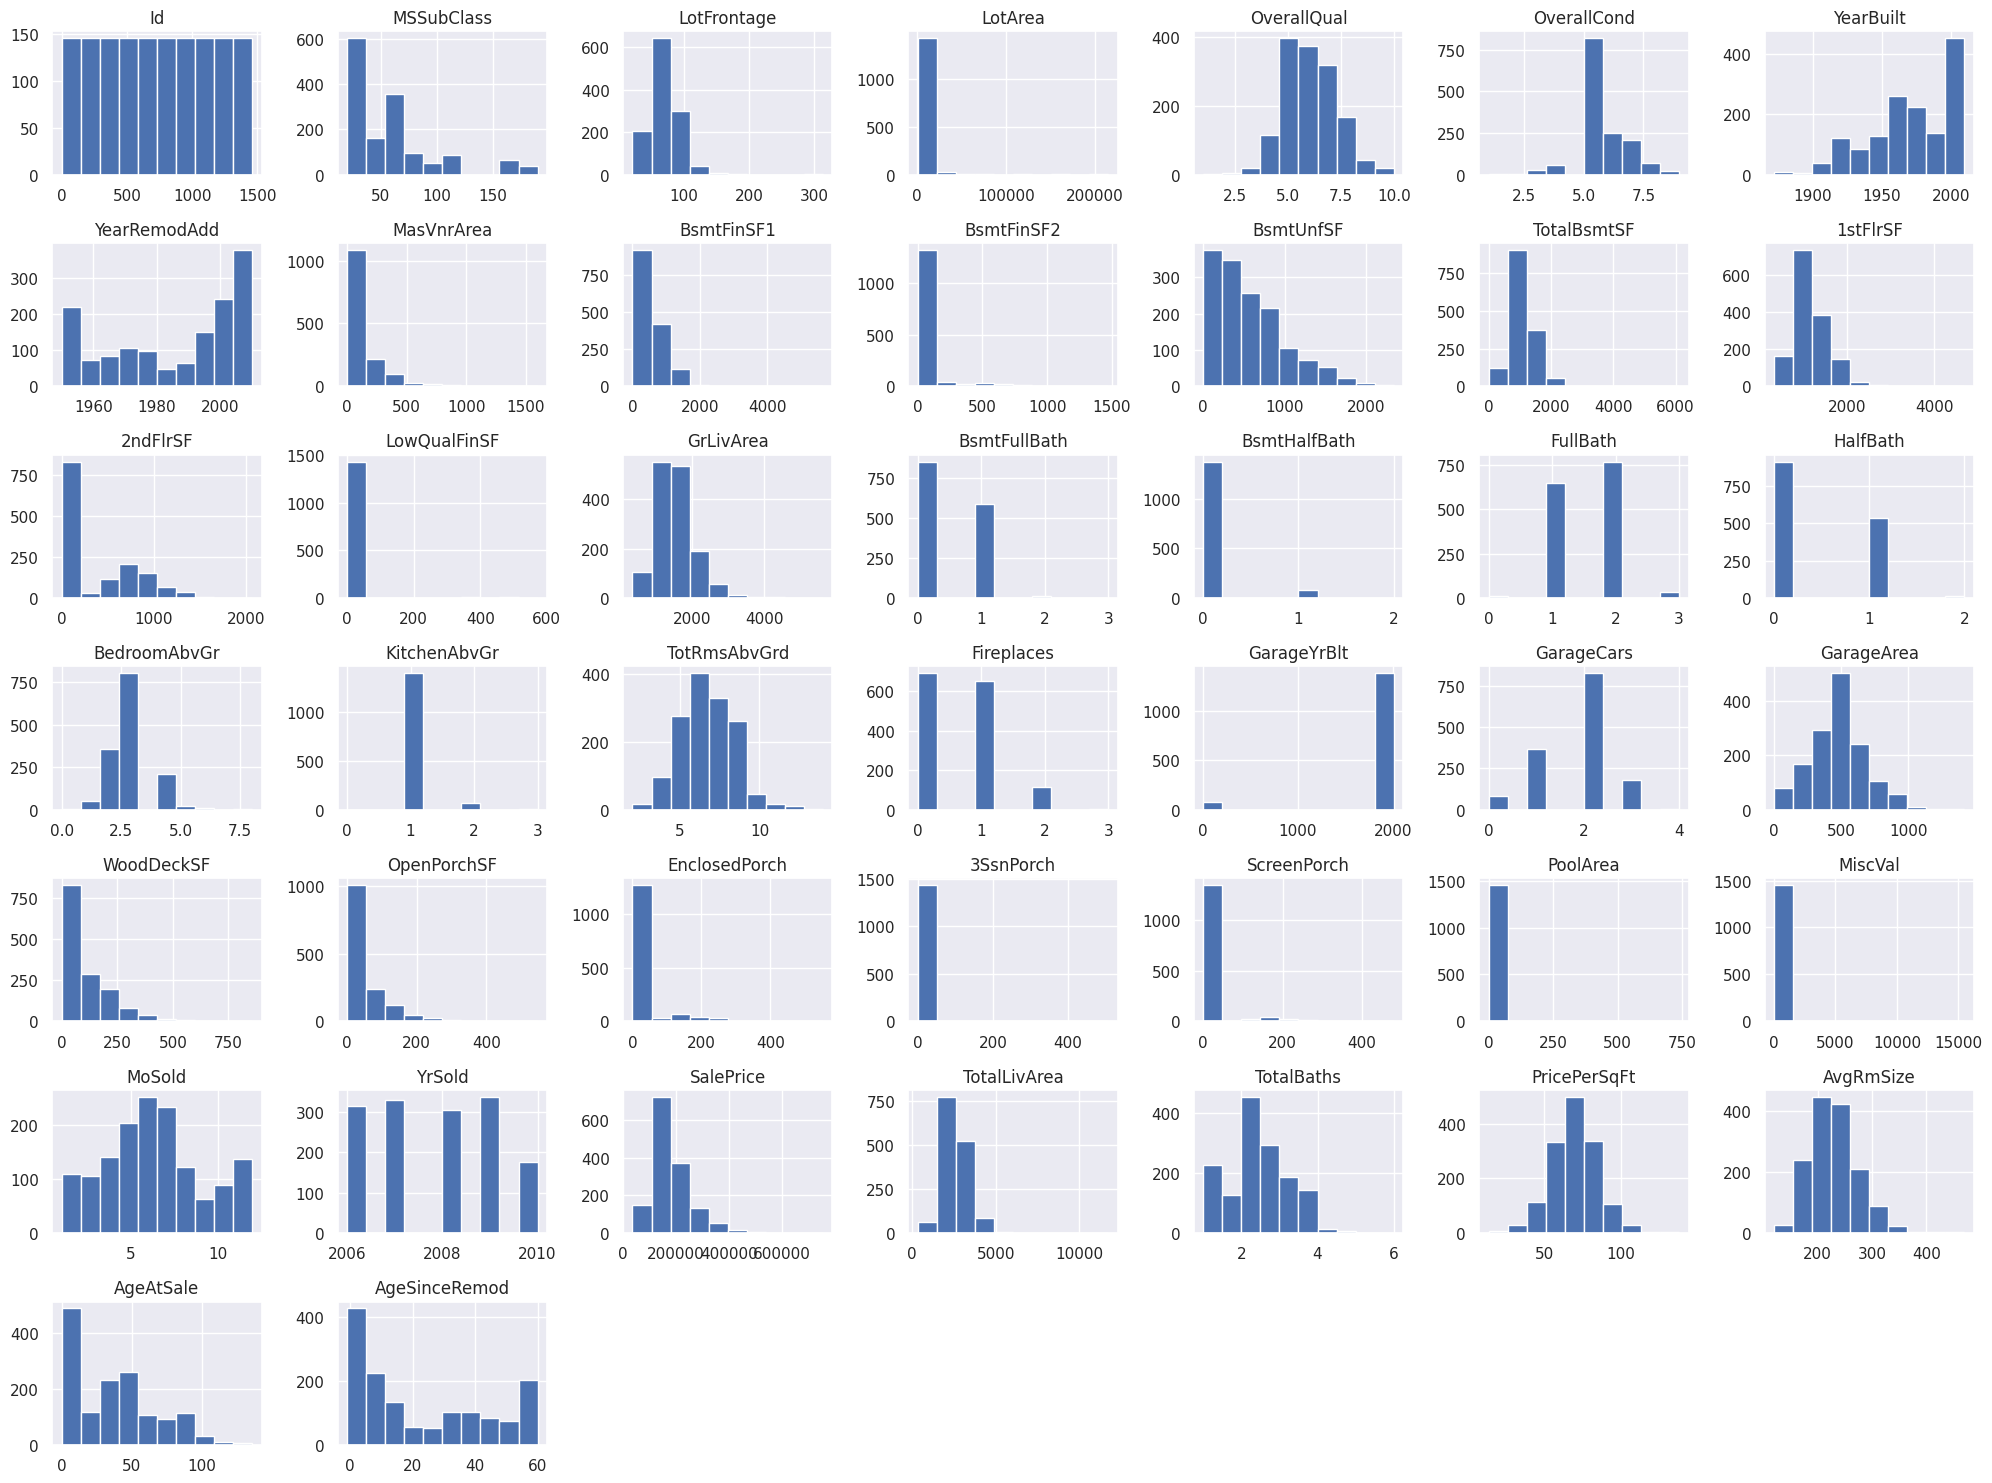

In [ ]:
%matplotlib inline
df_train.hist(bins=10, figsize=(20,15))
plt.tight_layout()
plt.show()

#### List of categorical features

In [ ]:
categorical_features = df_train.select_dtypes(include=['object']).columns.tolist()
print(categorical_features)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


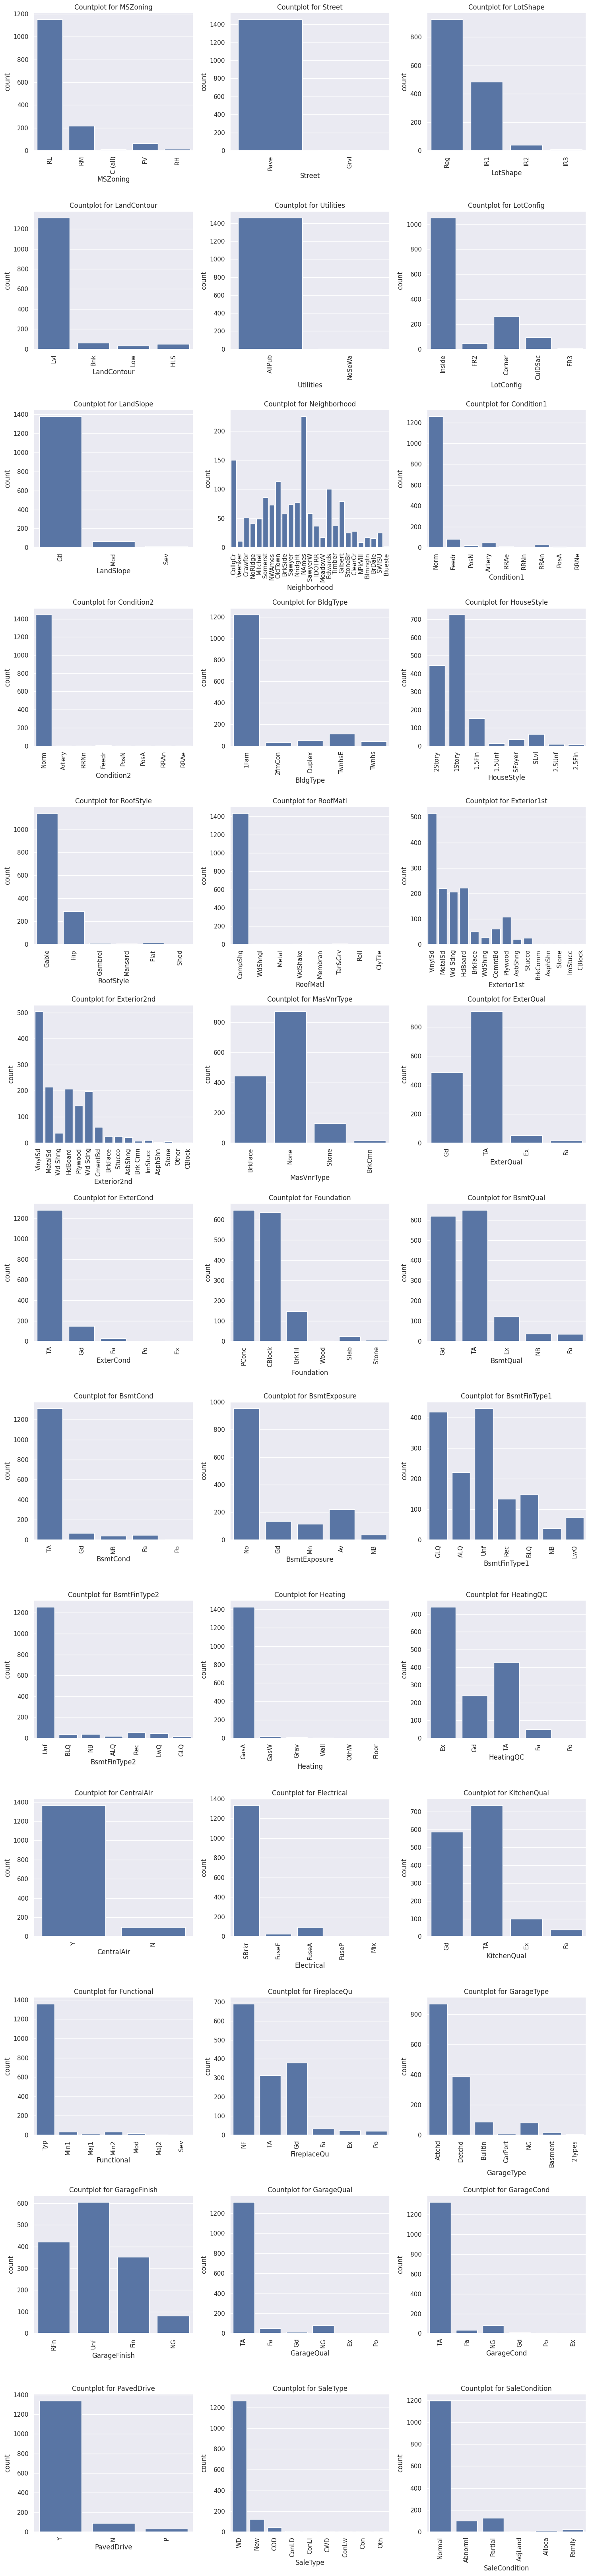

In [ ]:
num_plots = len(categorical_features)
num_cols = 3  # Adjust as needed
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))  # Adjust figsize as needed

# Iterate and plot on subplots
for i, column in enumerate(categorical_features):
    row = i // num_cols
    col = i % num_cols
    sns.countplot(x=column, data=df_train, ax=axes[row, col])
    axes[row, col].set_title(f"Countplot for {column}")
    axes[row, col].tick_params(axis='x', rotation=90)  # Rotate x-axis labels

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

### Exploratory Data Analysis

#### Identifying important numerical features

In [ ]:
corr_matrix = df_train[numeric_features].corr().abs()
corr_matrix["SalePrice"].sort_values(ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
TotalLivArea,0.778959
GrLivArea,0.708624
PricePerSqFt,0.640819
GarageCars,0.640409
TotalBaths,0.631731
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852


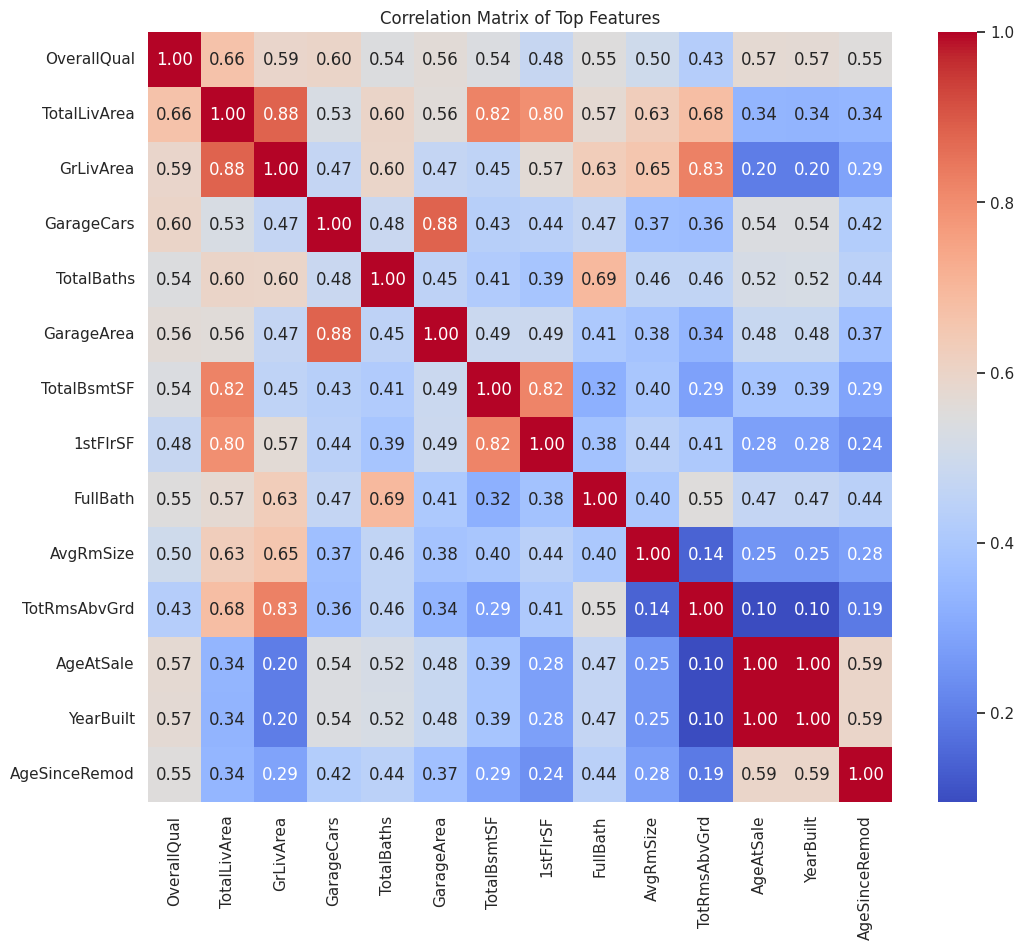

In [ ]:
# Calculate the correlation matrix
corr_matrix = df_train[numeric_features].corr()

# Get the top features correlated with SalePrice (excluding SalePrice and PricePerSqFt)
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(16).index
top_features = top_features.drop(['PricePerSqFt', 'SalePrice'])
top_features_corr_matrix = df_train[top_features].corr()

# Create a correlation matrix for the remaining top features
plt.figure(figsize=(12, 10))
sns.heatmap(top_features_corr_matrix.abs(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Top Features')
plt.show()

**TAKEAWAY:** A lot of the best predictors of SalePrice are highly correlated with each other

#### Scaling important numerical features

##### TotalLivArea

Added a quadratic term "TotalLivArea_squared" after analysis.

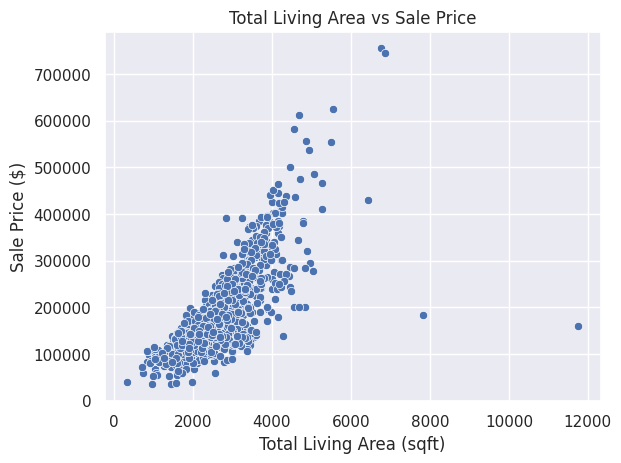

In [ ]:
# Create the scatter plot using Seaborn, with hue based on 'HasBasement'
sns.scatterplot(x='TotalLivArea', y='SalePrice', data=df_train)

# Customize the plot (optional)
plt.title('Total Living Area vs Sale Price')
plt.xlabel('Total Living Area (sqft)')
plt.ylabel('Sale Price ($)')

# Show the plot
plt.show()

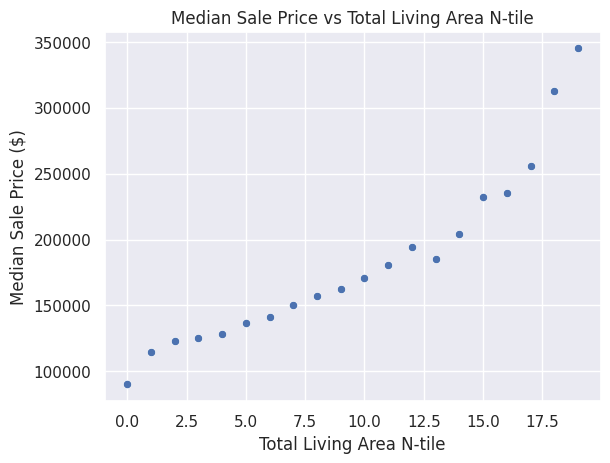

In [ ]:
# Create n-tiles (20 n-tiles) based on TotalLivArea
df_train['TotalLivArea_ntile'] = pd.qcut(df_train['TotalLivArea'], q=20, labels=False)

# Calculate the median SalePrice for each n-tile
median_prices_by_ntile = df_train.groupby('TotalLivArea_ntile')['SalePrice'].median().reset_index()

# Create the scatter plot using the median prices by n-tile
sns.scatterplot(x='TotalLivArea_ntile', y='SalePrice', data=median_prices_by_ntile)  # Change here

# Customize the plot
plt.title('Median Sale Price vs Total Living Area N-tile')  # Change here
plt.xlabel('Total Living Area N-tile')  # Change here
plt.ylabel('Median Sale Price ($)')

# Show the plot
plt.show()

The above plot shows a potential quadratic effect.

In [ ]:
#Add a quadratic term for TotalLivArea
df_train['TotalLivArea_squared'] = df_train['TotalLivArea'] ** 2
df_test['TotalLivArea_squared'] = df_test['TotalLivArea'] ** 2

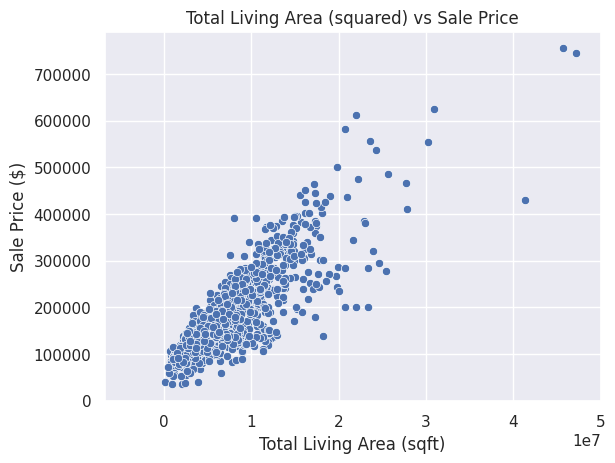

In [ ]:
# Create the scatter plot using Seaborn, with hue based on 'HasBasement'
sns.scatterplot(x='TotalLivArea_squared', y='SalePrice', data=df_train)

# Customize the plot (optional)
plt.title('Total Living Area (squared) vs Sale Price')
plt.xlabel('Total Living Area (sqft)')
plt.ylabel('Sale Price ($)')
plt.xlim(right=50000000)

# Show the plot
plt.show()

Looks more linear when plotting against quadratic term.

##### AvgRmSize

Has a linear relationship with SalePrice

In [ ]:
df_train.groupby('BldgType')[['SalePrice', 'AvgRmSize']].describe()

SalePrice                                                            \
             count           mean           std      min       25%       50%   
BldgType                                                                       
1Fam        1220.0  185763.807377  82648.502922  34900.0  131475.0  167900.0   
2fmCon        31.0  128432.258065  35458.545158  55000.0  106875.0  127500.0   
Duplex        52.0  133541.076923  27833.249197  82000.0  118375.0  135980.0   
Twnhs         43.0  135911.627907  41013.222080  75000.0   95750.0  137500.0   
TwnhsE       114.0  181959.342105  60626.108918  75500.0  143187.5  172200.0   

                             AvgRmSize                                     \
               75%       max     count        mean        std         min   
BldgType                                                                    
1Fam      222000.0  755000.0    1220.0  230.178106  44.676834  120.000000   
2fmCon    142500.0  228950.0      31.0  215.107401  33.628369  150.800000   
Duplex    145000.0  206300.0      52.0  205.434188  25.878809  163.200000   
Twnhs     168750.0  230000.0      43.0  231.042968  38.560803  174.000000   
TwnhsE    207375.0  392500.0     114.0  254.550731  47.125055  176.666667   

                                                          
                 25%         50%         75%         max  
BldgType                                                  
1Fam      198.666667  226.666667  255.723214  470.166667  
2fmCon    187.761905  215.400000  237.700000  273.142857  
Duplex    185.000000  204.000000  219.875000  264.000000  
Twnhs     201.728571  219.000000  254.583333  314.600000  
TwnhsE    218.283333  245.700000  282.666667  378.000000

**TAKEAWAY:** BldgType, doesn't seem to have a major impact on the AvgRmSize.

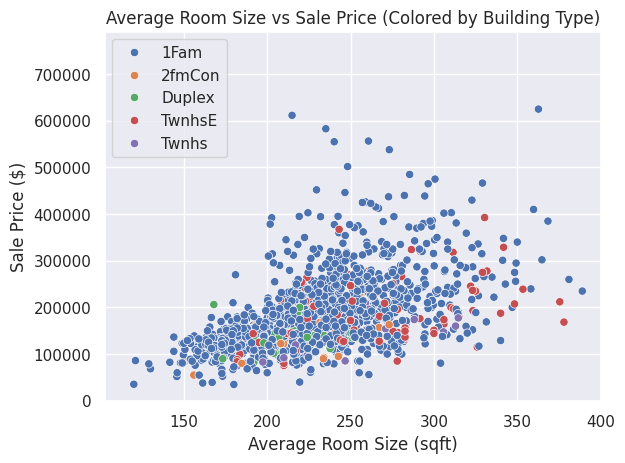

In [ ]:
# Create the scatter plot using Seaborn, with hue based on 'BldgType'
sns.scatterplot(x='AvgRmSize', y='SalePrice', hue='BldgType', data=df_train)

# Customize the plot (optional)
plt.title('Average Room Size vs Sale Price (Colored by Building Type)')  # Updated title
plt.xlabel('Average Room Size (sqft)')  # Updated x-axis label
plt.ylabel('Sale Price ($)')
plt.legend()  # Show legend for BldgType
plt.xlim(right=400)

# Show the plot
plt.show()

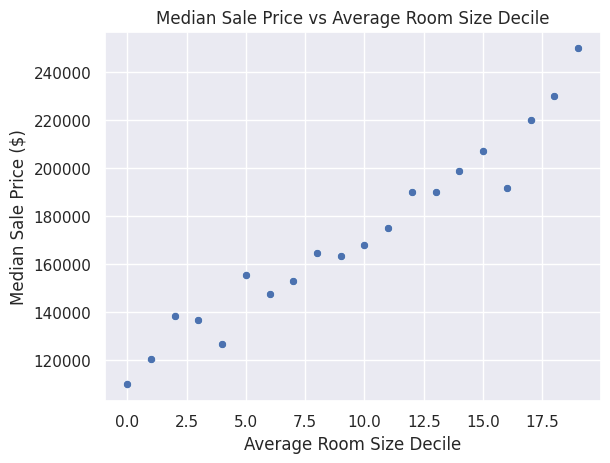

In [ ]:
# Create deciles (20 deciles) based on AvgRmSize
df_train['AvgRmSize_decile'] = pd.qcut(df_train['AvgRmSize'], q=20, labels=False)

# Calculate the median SalePrice for each decile
median_prices_by_decile = df_train.groupby('AvgRmSize_decile')['SalePrice'].median().reset_index()

# Create the scatter plot using the median prices by decile
sns.scatterplot(x='AvgRmSize_decile', y='SalePrice', data=median_prices_by_decile)

# Customize the plot
plt.title('Median Sale Price vs Average Room Size Decile')  # Updated title
plt.xlabel('Average Room Size Decile')
plt.ylabel('Median Sale Price ($)')

# Show the plot
plt.show()

##### AgeAtSale

Added a log term "AgeAtSale_log" after analysis.*italicized text*

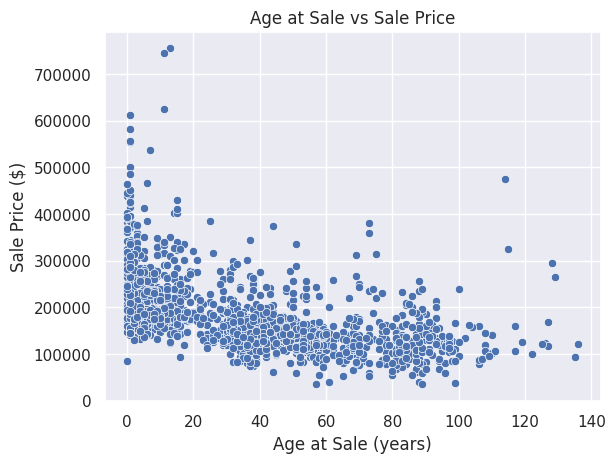

In [ ]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='AgeAtSale', y='SalePrice', data=df_train)

# Customize the plot (optional)
plt.title('Age at Sale vs Sale Price')  # Updated title
plt.xlabel('Age at Sale (years)')  # Updated x-axis label
plt.ylabel('Sale Price ($)')

# Show the plot
plt.show()

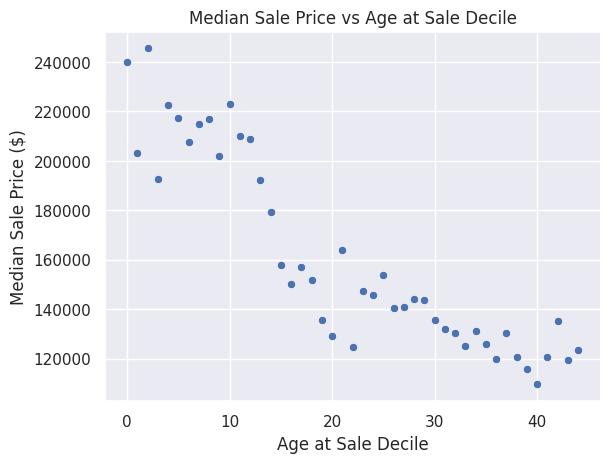

In [ ]:
# Create deciles (50 deciles) based on AgeAtSale
df_train['AgeAtSale_decile'] = pd.qcut(df_train['AgeAtSale'], q=50, labels=False, duplicates='drop')

# Calculate the median SalePrice for each decile
median_prices_by_decile = df_train.groupby('AgeAtSale_decile')['SalePrice'].median().reset_index()

# Create the scatter plot using the median prices by decile
sns.scatterplot(x='AgeAtSale_decile', y='SalePrice', data=median_prices_by_decile)

# Customize the plot
plt.title('Median Sale Price vs Age at Sale Decile')  # Updated title
plt.xlabel('Age at Sale Decile')  # Updated x-axis label
plt.ylabel('Median Sale Price ($)')

# Show the plot
plt.show()

Looks like there is a logarithmic effect.

In [ ]:
#Add a logarithmic term for AgeAtSale
epsilon = 0.001
df_train['AgeAtSale_log'] = np.log1p(df_train['AgeAtSale'] + epsilon)
df_test['AgeAtSale_log'] = np.log1p(df_test['AgeAtSale'] + epsilon)

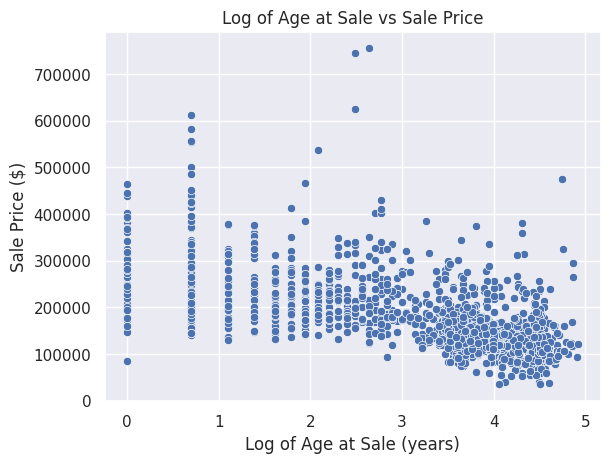

In [ ]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='AgeAtSale_log', y='SalePrice', data=df_train)

# Customize the plot (optional)
plt.title('Log of Age at Sale vs Sale Price')  # Updated title
plt.xlabel('Log of Age at Sale (years)')  # Updated x-axis label
plt.ylabel('Sale Price ($)')

# Show the plot
plt.show()

##### Standard Scaling

In [ ]:
# Initialize scalers for each feature (or reuse one if you prefer)
scaler_total = StandardScaler()
scaler_squared = StandardScaler()
scaler_avg_room = StandardScaler()
scaler_age = StandardScaler()
scaler_log_age = StandardScaler()

# Fit on training set
df_train['TotalLivArea_std'] = scaler_total.fit_transform(df_train[['TotalLivArea']])
df_train['TotalLivArea_squared_std'] = scaler_squared.fit_transform(df_train[['TotalLivArea_squared']])
df_train['AvgRmSize_std'] = scaler_avg_room.fit_transform(df_train[['AvgRmSize']])
df_train['AgeAtSale_std'] = scaler_age.fit_transform(df_train[['AgeAtSale']])
df_train['AgeAtSale_log_std'] = scaler_log_age.fit_transform(df_train[['AgeAtSale_log']])

# Transform test set using previously fit scalers
df_test['TotalLivArea_std'] = scaler_total.transform(df_test[['TotalLivArea']])
df_test['TotalLivArea_squared_std'] = scaler_squared.transform(df_test[['TotalLivArea_squared']])
df_test['AvgRmSize_std'] = scaler_avg_room.transform(df_test[['AvgRmSize']])
df_test['AgeAtSale_std'] = scaler_age.transform(df_test[['AgeAtSale']])
df_test['AgeAtSale_log_std'] = scaler_log_age.transform(df_test[['AgeAtSale_log']])

### Regression Analysis

#### Simple linear regression 1
features used 'OverallQual', 'TotalLivArea', 'GarageCars', 'AvgRmSize' and 'AgeAtSale'

In [ ]:
# Select the features and target variable
features = ['OverallQual', 'TotalLivArea_std', 'TotalLivArea_squared_std', 'GarageCars', 'AvgRmSize_std', 'AgeAtSale_std', 'AgeAtSale_log_std']
target = 'SalePrice'

# Create feature and target DataFrames for training
X = df_train[features]
y = df_train[target]

# Add constant term
X = sm.add_constant(X)

# Create and fit model
reg1 = sm.OLS(y, X)
results = reg1.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     703.2
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:45:11   Log-Likelihood:                -17464.
No. Observations:                1460   AIC:                         3.494e+04
Df Residuals:                    1452   BIC:                         3.499e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

Correlation: 0.8787520316171245
RMSE: 37,903
MAE: 25,174
R² Score: 0.7722


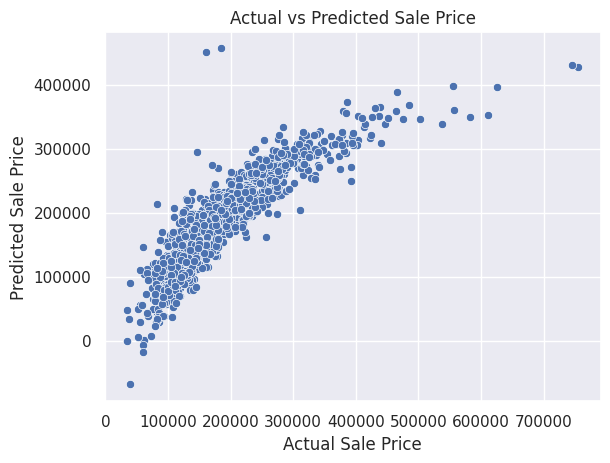

In [ ]:
# Add predictions to the training dataset
df_train['reg1_SalePrice'] = results.predict(sm.add_constant(df_train[features]))

# Calculate correlation between actual and predicted SalePrice
correlation = df_train['SalePrice'].corr(df_train['reg1_SalePrice'])
rmse = np.sqrt(mean_squared_error(df_train['SalePrice'], df_train['reg1_SalePrice']))
mae = mean_absolute_error(df_train['SalePrice'], df_train['reg1_SalePrice'])
r2 = r2_score(df_train['SalePrice'], df_train['reg1_SalePrice'])

# Print the correlation
print(f"Correlation: {correlation}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAE: {mae:,.0f}")
print(f"R² Score: {r2:.4f}")

# Create a scatter plot to visualize the relationship
sns.scatterplot(x='SalePrice', y='reg1_SalePrice', data=df_train)
plt.title('Actual vs Predicted Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

In [ ]:
# Add predictions to test dataset
df_test['reg1_SalePrice'] = results.predict(sm.add_constant(df_test[features]))

# Fill blank in reg1_SalePrice with median reg1_SalePrice
# median_reg1_SalePrice = df_test['reg1_SalePrice'].median()
# df_test['reg1_SalePrice'] = df_test['reg1_SalePrice'].fillna(median_reg1_SalePrice)

In [ ]:
# saving prediction into another dataset
df_test[['Id', 'reg1_SalePrice']].to_csv('reg1_prediction.csv', index=False)